### Chandra data handling tutorial

Goals:
1. Figure out how to deal with event data
2. Figure out how to run SHERPA and/or CIAO through python
3. Create data products like images and spectra from the event file

In [54]:
import hyperscreen
from sherpa.astro.ui import *
from pycrates import *   
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from IPython.core.display import Image
import os
from pycrates import read_file
import numpy as np
%matplotlib  

Using matplotlib backend: MacOSX


In [3]:
hrc_id = 1505

In [4]:
print(os.listdir(str(hrc_id)+'/primary/'))
# Useful data intro here - https://cxc.cfa.harvard.edu/ciao/threads/intro_data/
# 
# .jpg files are images
# evt2.fits is created from evt1 files using whatever calibration Chandra is currently using
# src2.fits is a source candidate list that can be superimposed on the data
# bpix1.fits is bad pixels according to the bad pixel dictionary (https://cxc.cfa.harvard.edu/ciao/dictionary/bpix.html)
# fov1.fits is a region file used to describe the edges of the chip
# eph1.fits is the orbit ephemeris needed for precision timing
# asol1.fits is the aspect solution which is the orientation of Chandra as a function of time
# dtf1.fits is the dead time correction factors as a function of time, only for HRC
# pha2.fits --> not available for HRC

['hrcf01505N005_full_img2.jpg', 'hrc_lc.fits', '.DS_Store', 'hrcf01505N005_cntr_img2.jpg', 'pcadf062007430N003_asol1.fits.gz', 'hrcf01505N005_src2.fits', 'hrcf01505N005_cntr_img2.fits.gz', 'pcadf061962921N003_asol1.fits.gz', 'orbitf061862464N002_eph1.fits.gz', 'hrcf01505_001N004_dtf1.fits.gz', 'hrcf01505N005_src_img2.jpg', 'hrcf01505_001N004_fov1.fits.gz', 'out.pha', 'hrcf01505_001N004_dtf1.fits', 'hrcf01505N005_evt2.fits', 'hrcf01505N005_full_img2.fits.gz']


In [7]:
evt1 = fits.open(str(hrc_id)+'/secondary/hrcf0'+str(hrc_id)+'_001N004_evt1.fits.gz')
evt2 = fits.open(str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_evt2.fits')


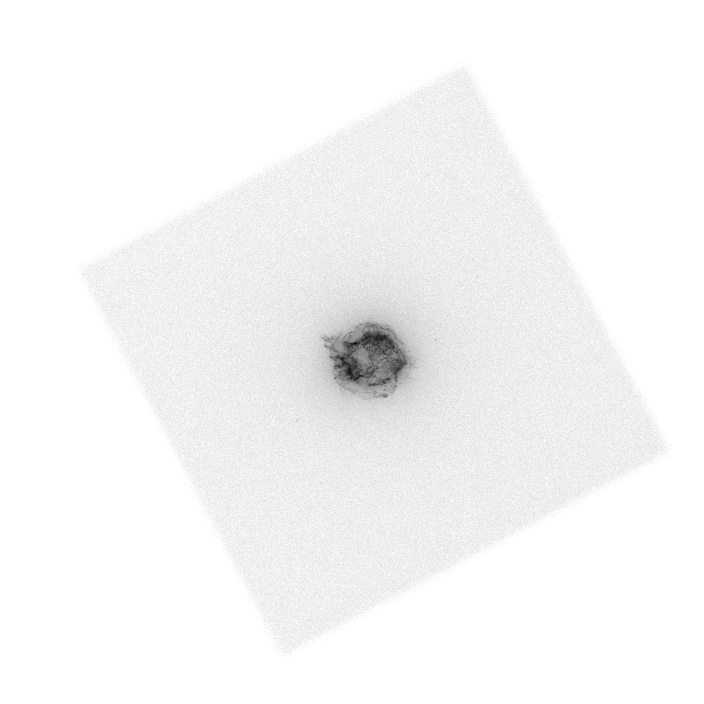

In [8]:
### the img2 files are usful for a quick look
# full_img2 is the full-field sky image:
Image(str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_full_img2.jpg')


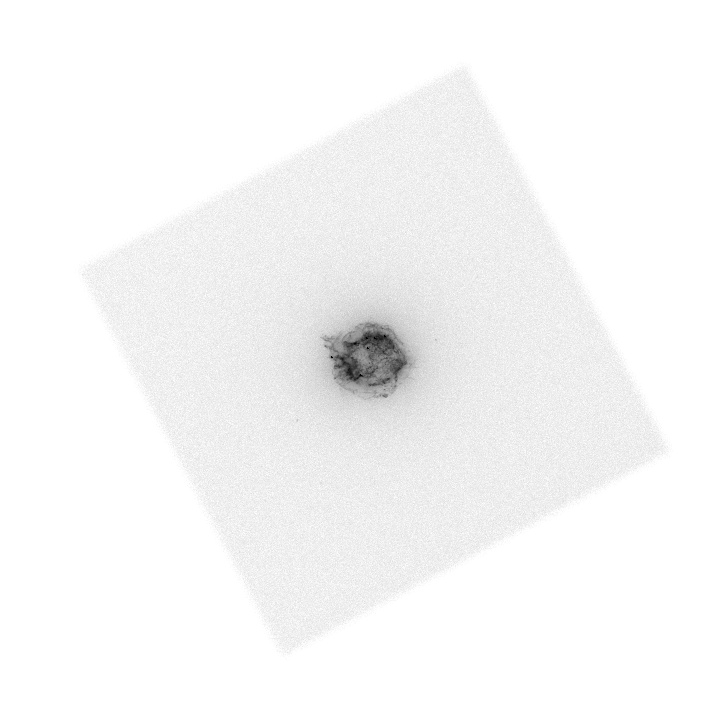

In [9]:
### src is the source candidates, but looks like it's the same as above?
Image(str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_src_img2.jpg')

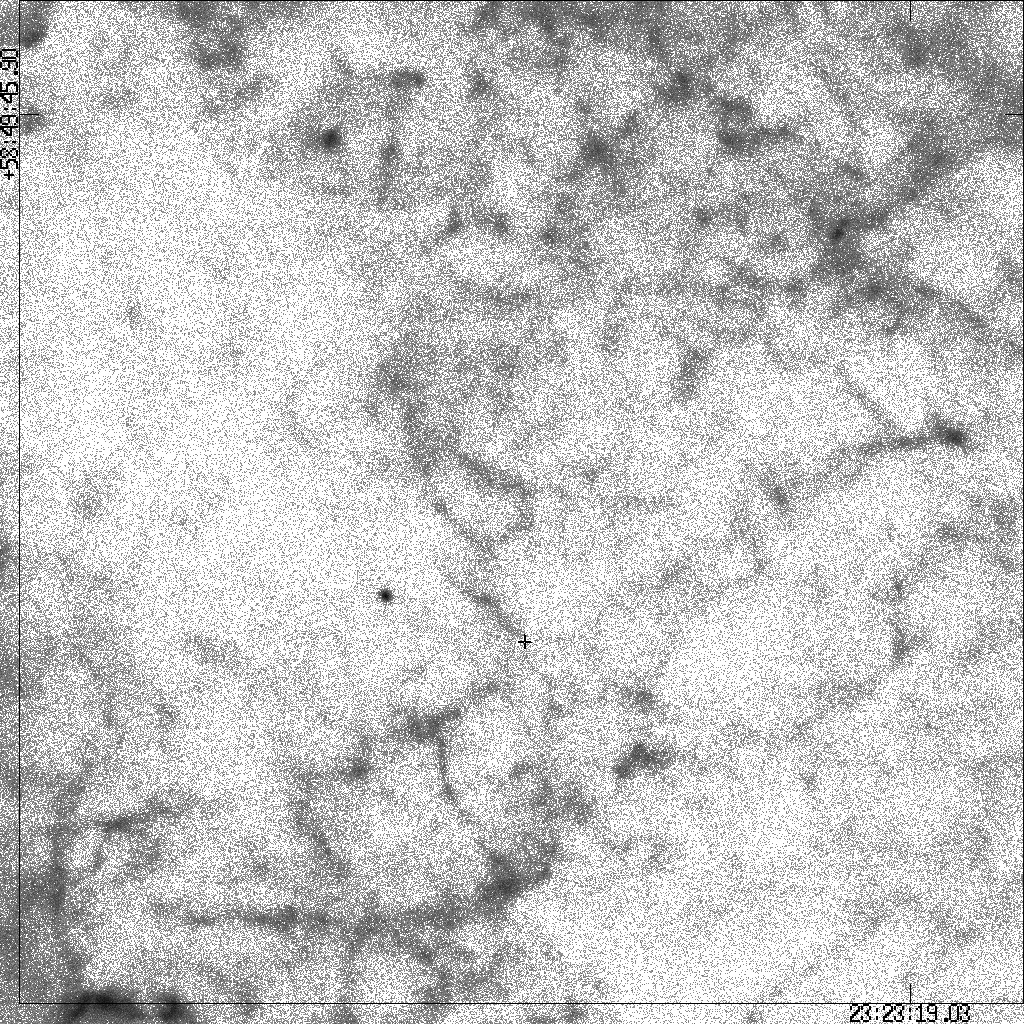

In [10]:
### cntr a high res view of the center
Image(str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_cntr_img2.jpg')

In [11]:
### The src1.fits file can be overlaid on the event file in ds9

# This is a helpful tutorial for doing this in ds9: https://cxc.cfa.harvard.edu/ciao/threads/detect_output/
# I've put it into os.system language so it can be run within python

os.system('ds9 '+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_evt2.fits &')
os.system('dmlist '+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_src2.fits blocks')
# you can also look at the individual sources:
os.system('dmlist '+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_src2.fits data')



0

### Now try to extract a light curve

The first step is to create a region file, which you can do using ds9 - see directions here:
https://cxc.cfa.harvard.edu/ciao/threads/regions/index.html#reg_format

To check what is in the region file, you can type 'cat ds9.reg'

I also loaded in the src.fits file and resaved it as a .reg file

In [43]:
# This prints out the columns in the event file
# this includes the time tags so that you can fill in the below with a time

os.popen('dmlist '+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_evt2.fits cols').read().split('\n')

[' ',
 '--------------------------------------------------------------------------------',
 'Columns for Table Block EVENTS',
 '--------------------------------------------------------------------------------',
 ' ',
 'ColNo  Name                 Unit        Type             Range',
 '   1   time                 s            Real8          61962615.2576930001: 62013968.7845529988 Time tag (TT)',
 '   2   chip(chipx,chipy)    pixel        Int2           1:16384              Chip coords',
 '   3   tdet(tdetx,tdety)    pixel        Int4           1:16384              Tdet coords',
 '   4   det(detx,dety)       pixel        Real4          0.50:    32768.50    Det coords',
 '   5   sky(x,y)             pixel        Real4          0.50:    32768.50    Sky coords',
 '   6   pha                  chan         Int2           0:255                Pulse height',
 '   7   pi                   chan         Int2           0:255                Pulse Invariant',
 '   8   chip_id                        

In [45]:
# This page is pretty useful for how to create light curves from HRC data:
# https://cxc.cfa.harvard.edu/ciao/why/lightcurve.html


# Use this to check out what the parameters are for extracting
os.system('plist dmextract')
os.system('punlearn dmextract')

# Use pset to set thte parameters
os.system('pset dmextract infile="'+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_evt2.fits[sky=region('+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_src2.reg)][bin time=61962615.3:62013968.78:100]"')
os.system('pset dmextract outfile='+str(hrc_id)+'/primary/hrc_lc.fits')
os.system('pset dmextract opt=ltc1') #
os.system('pset dmextract exp='+str(hrc_id)+'/primary/hrcf01505_001N004_dtf1.fits')
os.system('pset dmextract clobber = yes')
os.system('plist dmextract')
os.system('dmextract')

# Ended up using the below:
# Because the above wasn't working?
#dmextract "hrcf01505N005_evt2.fits[sky=region(hrcf01505N005_src2.reg)][bin time=61962615.3:62013968.78:100]"

# What are these different file types?:
# Output file type  (pha1|pha2|ltc1|ltc2|generic|generic2)

# This describes more: https://cxc.harvard.edu/ciao/ahelp/dmextract.html


65280

In [69]:

#os.system('dmlist out.pha cols')
# Theres also a way to do this verbose
os.popen('dmlist '+str(hrc_id)+'/primary/hrc_lc.fits cols').read().split('\n')

[' ',
 '--------------------------------------------------------------------------------',
 'Columns for Table Block LIGHTCURVE',
 '--------------------------------------------------------------------------------',
 ' ',
 'ColNo  Name                 Unit        Type             Range',
 '   1   TIME_BIN             channel      Int4           1:514                Time tag (TT)',
 '   2   TIME_MIN             s            Real8          61962615.2576930001: 62013968.7845529988 Minimum Value in Bin',
 '   3   TIME                 s            Real8          61962615.2576930001: 62013968.7845529988 Time tag (TT)',
 '   4   TIME_MAX             s            Real8          61962615.2576930001: 62013968.7845529988 Maximum Value in Bin',
 '   5   COUNTS               count        Int4           -                    Counts',
 '   6   STAT_ERR             count        Real8          0:+Inf               Statistical error',
 '   7   AREA                 pixel**2     Real8          -Inf:+Inf    

In [82]:
# Now plot the LC, which gives you the count rate at every point in time :)


plt.clf()
plt.subplots(2,1,sharex="col")
plt.subplots_adjust(hspace=0.4)
plt.subplot(2,1,1)
tab = read_file(str(hrc_id)+'/primary/hrc_lc.fits')
dt = tab.get_column("dt")#was dt
rate = tab.get_column("count_rate")
erate = tab.get_column("count_rate_err")
plt.errorbar(dt.values, rate.values, yerr=erate.values, marker="o", color="red", mfc="black",mec="black", ecolor="grey")
plt.xlabel(r"$\Delta$ T (s)")
plt.ylabel("Count rate (count/s)")
plt.title('HRC ID = '+str(hrc_id))
plt.ylim([np.mean(rate.values)-5,np.mean(rate.values)+5])
plt.subplot(2,1,2)
ee = tab.get_column("EXPOSURE")
plt.plot(dt.values, ee.values,marker="o", color="red", mfc="black",mec="black")
plt.xlabel(r"$\Delta$ T (s)")
plt.ylabel("Exposure Time (s)")
plt.ylim([np.mean(ee.values)-10, np.mean(ee.values)+10])
plt.show()


### The next goal would be to extract this data along other axes, maybe the imaging and/or spectral

To do in terms of energy, I'm guessing you can use dmextract again but this time to bin on the energy axis.

Maybe this is PHA (pulse height)?

In [90]:
#os.chdir('/Users/beckynevin/CfA_Code/HRC/'+str(hrc_id)+'/primary/')


os.system('plist dmextract')
os.system('punlearn dmextract')

# Use pset to set thte parameters
# Region options: hrcf0'+str(hrc_id)+'N005_src2
os.system('pset dmextract opt=pha1') #
os.system('pset dmextract exp="'+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'_001N004_dtf1.fits"')
os.system('pset dmextract clobber = yes')
os.system('pset dmextract verbose = 1')
os.system('plist dmextract')

# Okay apparently, you need to extract everything on one line
os.system('dmextract "'+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_evt2.fits[sky=region('+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_src2.reg)][bin pha=1:2048:2]" '+str(hrc_id)+'/primary/pha_bin.fits')


0

In [93]:
# Theres also a way to do this verbose
os.popen('dmlist '+str(hrc_id)+'/primary/pha_bin.fits cols').read().split('\n')

[' ',
 '--------------------------------------------------------------------------------',
 'Columns for Table Block SPECTRUM',
 '--------------------------------------------------------------------------------',
 ' ',
 'ColNo  Name                 Unit        Type             Range',
 '   1   CHANNEL              channel      Int4           1:1024               PHA',
 '   2   PHA                  chan         Real8          0:      255.0        Pulse height',
 '   3   COUNTS               count        Int4           -                    Counts',
 '   4   COUNT_RATE           count/s      Real8          0:+Inf               Rate',
 '']

In [85]:
# Theres also a way to do this verbose
os.popen('dmlist '+str(hrc_id)+'/primary/pha_bin.fits data').read().split('\n')

[' ',
 '--------------------------------------------------------------------------------',
 'Data for Table Block SPECTRUM',
 '--------------------------------------------------------------------------------',
 ' ',
 'ROW    SPEC_NUM   CHANNEL[1024]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [109]:
# This one uses the mission defaults and bins on PI instead:
os.system('dmextract "'+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_evt2.fits[sky=region('+str(hrc_id)+'/primary/ds9.reg)][bin pi]" '+str(hrc_id)+'/primary/output.pha')


0

In [110]:
# Theres also a way to do this verbose
os.popen('dmlist '+str(hrc_id)+'/primary/output.pha cols').read().split('\n')

[' ',
 '--------------------------------------------------------------------------------',
 'Columns for Table Block SPECTRUM',
 '--------------------------------------------------------------------------------',
 ' ',
 'ColNo  Name                 Unit        Type             Range',
 '   1   CHANNEL              channel      Int4           1:256                PI',
 '   2   PI                   chan         Real8          0:      255.0        Pulse Invariant',
 '   3   COUNTS               count        Int4           -                    Counts',
 '   4   COUNT_RATE           count/s      Real8          0:+Inf               Rate',
 '']

In [118]:
# Okay time to plot it up


plt.clf()
plt.subplots(2,1,sharex="col")
plt.subplots_adjust(hspace=0.4)
plt.subplot(1,1,1)
tab = read_file(str(hrc_id)+'/primary/output.pha')
dt = tab.get_column("PI")#was dt
rate = tab.get_column("counts")
#erate = tab.get_column("count_rate_err")

#plt.errorbar(dt.values, rate.values,  marker="o", linestyle='None', mfc="black",mec="black", ecolor="grey")
plt.step(dt.values, rate.values, color='orange')
plt.xlabel(r"$\Delta$ E (s)")
plt.ylabel("Counts")
plt.title('Spectrum HRC ID = '+str(hrc_id))
#plt.ylim([np.mean(rate.values)-5,np.mean(rate.values)+5])
plt.xlim([0,max(dt.values)-1])
plt.ylim([0,np.sort(rate.values)[-2]+np.sort(rate.values)[-2]/5])
#plt.subplot(2,1,2)
'''ee = tab.get_column("EXPOSURE")
plt.plot(dt.values, ee.values,marker="o", color="red", mfc="black",mec="black")
plt.xlabel(r"$\Delta$ T (s)")
plt.ylabel("Exposure Time (s)")
plt.ylim([np.mean(ee.values)-10, np.mean(ee.values)+10])
'''
plt.show()


In [119]:
os.system('plist specextract')

0

In [43]:
# Actually run it
os.system('dmextract')

65280

In [44]:
os.system('dmlist '+str(hrc_id)+'/primary/hrc_lc.fits cols')


0

In [47]:
os.system('dmextract '+str(hrc_id)+'/primary/hrcf0'+str(hrc_id)+'N005_evt2.fits.gz opt=ltc1 lc.fits')

33280

In [43]:
print(evt2[0].header)

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H HDUNAME = 'PRIMARY '                                                            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H LONGSTRN= 'OGIP 1.0'           / The HEASARC Long String Convention may be used.COMMENT   This FITS file may contain long string keyword values that are        COMMENT   continued over multiple keywords.  The HEASARC convention uses the &  COMMENT   character at the end of each s

In [27]:
print(type(evt2[1].data))
# Each event file contains numerous different pieces of data - 
# time, chipx, chipy, tdetx, tdety, detx, dety, x, y, pha, pi, chip_id, status
print(evt2[1].columns)
print(evt2[1].data['status'])
STOP
print(evt2[1].data)

plt.clf()
plt.imshow(evt2[1].data)
plt.show()

<class 'astropy.io.fits.fitsrec.FITS_rec'>
ColDefs(
    name = 'time'; format = '1D'; unit = 's'
    name = 'chipx'; format = '1I'; unit = 'pixel'; coord_type = 'CPCX'; coord_unit = 'mm'; coord_ref_point = 0.5; coord_ref_value = 0.0; coord_inc = 0.0064294
    name = 'chipy'; format = '1I'; unit = 'pixel'; coord_type = 'CPCY'; coord_unit = 'mm'; coord_ref_point = 0.5; coord_ref_value = 0.0; coord_inc = 0.0064294
    name = 'tdetx'; format = '1J'; unit = 'pixel'
    name = 'tdety'; format = '1J'; unit = 'pixel'
    name = 'detx'; format = '1E'; unit = 'pixel'; coord_type = 'LONG-TAN'; coord_unit = 'deg'; coord_ref_point = 16384.5; coord_ref_value = 0.0; coord_inc = 3.6611111111111e-05
    name = 'dety'; format = '1E'; unit = 'pixel'; coord_type = 'NPOL-TAN'; coord_unit = 'deg'; coord_ref_point = 16384.5; coord_ref_value = 0.0; coord_inc = 3.6611111111111e-05
    name = 'x'; format = '1E'; unit = 'pixel'; coord_type = 'RA---TAN'; coord_unit = 'deg'; coord_ref_point = 16384.5; coord_ref_va

NameError: name 'STOP' is not defined

In [11]:
set_stat("cash")
set_method('moncar')

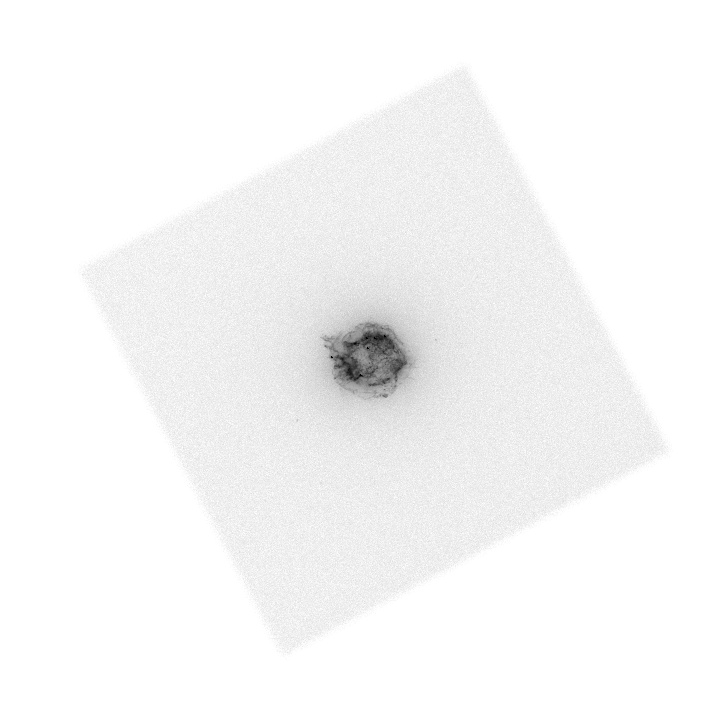

In [15]:
Image('1505/primary/hrcf01505N005_src_img2.jpg')

In [18]:
set_coord("physical")
ignore2d("ignore.reg")
set_coord("logical")
image_data()

IdentifierErr: No data sets found

In [19]:
dmlist

NameError: name 'dmlist' is not defined